In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sqlite3
from sqlite3 import Error
from sklearn.linear_model import LinearRegression
from tsmoothie.smoother import *

In [3]:
def connect_to_database(db_file):
    """ create a database connection to the SQLite database
        specified by the db_file
    :param db_file: database file
    :return: Connection object or None
    """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
    except Error as e:
        print(e)

    return conn

In [4]:
DB_FILE = 'data/reddit_50_both_inferred.db'

# get connection with database
conn = connect_to_database(DB_FILE)
cur = conn.cursor()
conn.text_factory = lambda b: b.decode(errors = 'ignore')

In [5]:
cur.execute("SELECT * FROM classified_clauses")
clauses_rows = cur.fetchall()

genericity_data = {}
aspect_data = {}
boundedness_data = {}
total_clause_count = {}

for row in clauses_rows:
    doc_id = row[0]
    genericity_predictions = row[2]
    aspect_predictions = row[4]
    boundedness_predictions = row[6]

    # get count of generic and specific
    generic_count = genericity_predictions.split(',').count('0')
    specific_count = genericity_predictions.split(',').count('1')
    
    # get count of dynamic and stative
    dynamic_count = aspect_predictions.split(',').count('0')
    stative_count = aspect_predictions.split(',').count('1')

    # get count of bounded and unbounded
    bounded_count = boundedness_predictions.split(',').count('0')
    unbounded_count = boundedness_predictions.split(',').count('1')

    cur.execute('SELECT * from comments where rowid=? and inferred_attitude=1 and inferred_persuasion=1;', (doc_id,))
    comment = cur.fetchone()
    if not comment:
        continue
    month = comment[3]
    year = comment[4]
    date = str(month) + '-' + str(year)

    if date in genericity_data:
        curr_generic_count = genericity_data[date][0]
        curr_specific_count = genericity_data[date][1]
        genericity_data[date] = [curr_generic_count + generic_count, curr_specific_count + specific_count]
    else:
        genericity_data[date] = [generic_count, specific_count]

    if date in aspect_data:
        curr_dynamic_count = aspect_data[date][0]
        curr_stative_count = aspect_data[date][1]
        aspect_data[date] = [curr_dynamic_count + dynamic_count, curr_stative_count + stative_count]
    else:
        aspect_data[date] = [dynamic_count, stative_count]

    if date in boundedness_data:
        curr_bounded_count = boundedness_data[date][0]
        curr_unbounded_count = boundedness_data[date][1]
        boundedness_data[date] = [curr_bounded_count + bounded_count, curr_unbounded_count + unbounded_count]
        total_clause_count[date] = total_clause_count[date] + (bounded_count + unbounded_count)
    else:
        boundedness_data[date] = [bounded_count, unbounded_count]
        total_clause_count[date] = bounded_count + unbounded_count

# genericity_data.pop('0-0')
# genericity_data.pop('121-8295')
# aspect_data.pop('0-0')
# aspect_data.pop('121-8295')
# boundedness_data.pop('0-0')
# boundedness_data.pop('121-8295')

In [8]:
tick_locs = [i*12 for i in range(13)]
ticks = [(2008+i) for i in range(13)]

In [10]:
import math

def get_confidence_intervals(props, data, class_type):
    up_ci = []
    low_ci = []
    for index, date in enumerate(data.keys()):
        standard_error = math.sqrt((props[index] * (1 - props[index]))/data[date][class_type])
        up_ci.append(props[index] + (standard_error * 1.96))
        low_ci.append(props[index] - (standard_error * 1.96))
    return low_ci, up_ci

generic_prop = {}
specific_prop = {}

for date in genericity_data.keys():
    total = genericity_data[date][0] + genericity_data[date][1]
    generic_prop[date] = genericity_data[date][0] / total
    specific_prop[date] = genericity_data[date][1] / total

bounded_prop = {}
unbounded_prop = {}
for date in boundedness_data.keys():
    total = boundedness_data[date][0] + boundedness_data[date][1]
    bounded_prop[date] = boundedness_data[date][0] / total
    unbounded_prop[date] = boundedness_data[date][1] / total

dynamic_prop = {}
stative_prop = {}
for date in aspect_data.keys():
    total = aspect_data[date][0] + aspect_data[date][1]
    dynamic_prop[date] = aspect_data[date][0] / total
    stative_prop[date] = aspect_data[date][1] / total

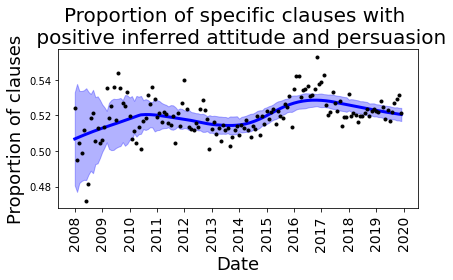

In [12]:
# genericity proportions

CLASS = 'SPECIFIC' # put in BOUNDED or UNBOUNDED

if CLASS == 'GENERIC':
    values = list(generic_prop.values())
    title = 'Proportion of generic clauses with \n positive inferred attitude and persuasion'
    filename = 'figures/props_smoothed_attitude_persuasion/generic_props_smoothed_confidence_a_p.png'
    props = generic_prop
    class_type = 0
elif CLASS == 'SPECIFIC':
    values = list(specific_prop.values())  
    title = 'Proportion of specific clauses with \n positive inferred attitude and persuasion'
    filename = 'figures/props_smoothed_attitude_persuasion/specific_props_smoothed_confidence_a_p.png'
    props = specific_prop
    class_type = 1

smoother = LowessSmoother(smooth_fraction=0.4, iterations=1)
smoother.smooth(values)
low_pi, up_pi = smoother.get_intervals('prediction_interval')
low_ci, up_ci = get_confidence_intervals(smoother.smooth_data[0], genericity_data, class_type)
# low_ci, up_ci = smoother.get_intervals('confidence_interval')
plt.plot(smoother.smooth_data[0], linewidth=3, color='blue')
plt.plot(smoother.data[0], '.k')
# plt.fill_between(range(len(smoother.data[0])), low_pi[0], up_pi[0], alpha=0.3, color='blue')
plt.fill_between(range(len(smoother.data[0])), low_ci, up_ci, alpha=0.3, color='blue')

plt.title(title, fontsize=20)
plt.xticks(tick_locs,ticks, rotation='vertical',fontsize=14)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Proportion of clauses', fontsize=18)
plt.tight_layout()
plt.savefig(filename, facecolor='w', transparent=False)
plt.show()

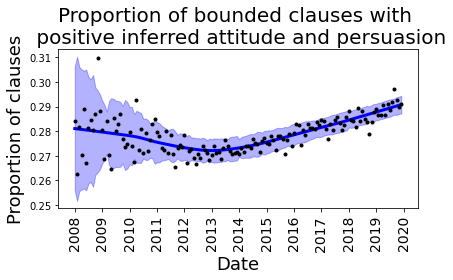

In [14]:
# boundedness proportions

CLASS = 'BOUNDED' # put in BOUNDED or UNBOUNDED

if CLASS == 'UNBOUNDED':
    values = list(unbounded_prop.values())
    title = 'Proportion of unbounded clauses with \n positive inferred attitude and persuasion'
    filename = 'figures/props_smoothed_attitude_persuasion/unbounded_props_smoothed_confidence_a_p.png'
    props = unbounded_prop
    class_type = 1
elif CLASS == 'BOUNDED':
    values = list(bounded_prop.values())  
    title = 'Proportion of bounded clauses with \n positive inferred attitude and persuasion'
    filename = 'figures/props_smoothed_attitude_persuasion/bounded_props_smoothed_confidence_a_p.png'
    props = bounded_prop
    class_type = 0

smoother = LowessSmoother(smooth_fraction=0.4, iterations=1)
smoother.smooth(values)
low_pi, up_pi = smoother.get_intervals('prediction_interval')
# low_ci, up_ci = smoother.get_intervals('confidence_interval')
low_ci, up_ci = get_confidence_intervals(smoother.smooth_data[0], boundedness_data, class_type)
plt.plot(smoother.smooth_data[0], linewidth=3, color='blue')
plt.plot(smoother.data[0], '.k')
# plt.fill_between(range(len(smoother.data[0])), low_pi[0], up_pi[0], alpha=0.3, color='blue')
plt.fill_between(range(len(smoother.data[0])), low_ci, up_ci, alpha=0.3, color='blue')

#plt.plot(bounded_prop.keys(), bounded_prop.values(), label='bounded')
# plt.plot(unbounded_prop.keys(), unbounded_prop.values(), label='unbounded')
plt.title(title, fontsize=20)
plt.xticks(tick_locs,ticks, rotation='vertical',fontsize=14)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Proportion of clauses', fontsize=18)
plt.tight_layout()
plt.savefig(filename, facecolor='w', transparent=False)
plt.show()

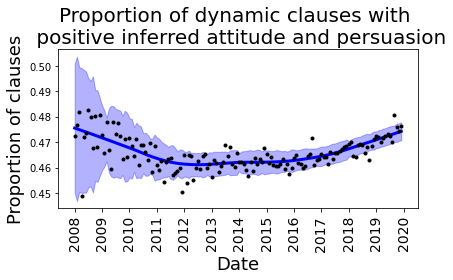

In [15]:
# aspect proportions

CLASS = 'STATIVE' # put in BOUNDED or UNBOUNDED

if CLASS == 'DYNAMIC':
    values = list(dynamic_prop.values())
    title = 'Proportion of dynamic clauses with \n positive inferred attitude and persuasion'
    filename = 'figures/props_smoothed_attitude_persuasion/dynamic_props_smoothed_confidence_a_p.png'
    props = dynamic_prop
    class_type = 0
elif CLASS == 'STATIVE':
    values = list(stative_prop.values())  
    title = 'Proportion of stative clauses with \n positive inferred attitude and persuasion'
    filename = 'figures/props_smoothed_attitude_persuasion/stative_props_smoothed_confidence_a_p.png'
    props = stative_prop
    class_type = 1

smoother = LowessSmoother(smooth_fraction=0.4, iterations=1)
smoother.smooth(values)
low_pi, up_pi = smoother.get_intervals('prediction_interval')
# low_ci, up_ci = smoother.get_intervals('confidence_interval')
low_ci, up_ci = get_confidence_intervals(smoother.smooth_data[0], aspect_data, class_type)
plt.plot(smoother.smooth_data[0], linewidth=3, color='blue')
plt.plot(smoother.data[0], '.k')
# plt.fill_between(range(len(smoother.data[0])), low_pi[0], up_pi[0], alpha=0.3, color='blue')
plt.fill_between(range(len(smoother.data[0])), low_ci, up_ci, alpha=0.3, color='blue')

plt.title(title, fontsize=20)
plt.xticks(tick_locs,ticks, rotation='vertical',fontsize=14)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Proportion of clauses', fontsize=18)
plt.tight_layout()
plt.savefig(filename, facecolor='w', transparent=False)
plt.show()